# 00.23 - QUEEN-NOQUEEN - NN Classification Train-Valid-Test

## Prerequisites

- The dataset exists (if not, execute 00 - Dataset Initialisation)
- The dataset features have been populated (if not, execute 02 - Features Computation)


In [2]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information
    predestination,                  # Seeds the various PRNGs for reproducibility 
    say_my_name                      # gets notebook name
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling

#########################
# Experiment parameters #
#########################

EXP_NAME = say_my_name()  # Experiment name will be used to create outputs directory

DATASET_NAME = 'MAIN1000' # Dataset name is the master key for dataset addressing
                          # Change it according to the dataset you want to process

FEATURE_NAME = 'mfcc20'   # Name of the feature used for classification
LABEL_NAME = 'queen'      # Name of the label used for classification

VALID_FRAC = 0.1
TEST_FRAC  = 0.3

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Build dataframe containing all the information needed to conduct the experiment
sql = F"SELECT {FEATURE_NAME}, {LABEL_NAME} FROM samples WHERE nobee = 0"
df = ds.queryDataFrame(sql)    
    
# Display AudioDataset summary    
ds.info()

[2020-09-02/15:17:23.607|14.1%|89.5%|0.35GB] ------------------------------------------------------
[2020-09-02/15:17:23.608|00.0%|89.5%|0.35GB] DATASET NAME          : MAIN1000
[2020-09-02/15:17:23.608|00.0%|89.5%|0.35GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-09-02/15:17:23.608|00.0%|89.5%|0.35GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-09-02/15:17:23.608|00.0%|89.5%|0.35GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-09-02/15:17:23.608|00.0%|89.5%|0.35GB] NB SOURCE AUDIO FILES : 48
[2020-09-02/15:17:23.608|00.0%|89.5%|0.35GB] SAMPLE RATE           : 22050
[2020-09-02/15:17:23.608|00.0%|89.5%|0.35GB] DURATION              : 1.0
[2020-09-02/15:17:23.609|00.0%|89.5%|0.35GB] OVERLAP               : 0.0
[2020-09-02/15:17:23.609|00.0%|89.5%|0.35GB] NB AUDIO CHUNKS       : 24788
[2020-09-02/15:17:23.609|00.0%|89.5%|0.35GB] ------------------------------------------------------


In [3]:
def simple_model(n_inputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=n_inputs))
    model.add(keras.layers.Dense(8, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(8, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"]
    )    
    
    return model

def simple_model2(n_inputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=n_inputs))
    model.add(keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
    #model.add(keras.layers.BatchNormalization())
    #model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
    #model.add(keras.layers.BatchNormalization())
    #model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy",
                  optimizer="nadam",
                  metrics=["accuracy"]
    )    
    
    return model

In [4]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from audace.splitters import splitTrainValidTest

# Seed the various PRNGs
predestination()

# Build training and test datasets
iprint(">>>>> Building partitions training/validation/test")
X_train, X_valid, X_test, y_train, y_valid, y_test = splitTrainValidTest(
    df,
    VALID_FRAC,
    TEST_FRAC,
    FEATURE_NAME,
    LABEL_NAME
)

# Standardize data 
iprint(">>>>> Standardize")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Build NN
iprint(">>>>> Build NN")
keras.backend.clear_session()
model = simple_model(X_train[0].shape)

print(F"Train on {len(X_train)}, validate on {len(X_valid)}, test on {len(X_test)}")

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, verbose=2, batch_size=64,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb]
          )

[2020-09-02/15:17:27.893|08.3%|87.9%|0.35GB] >>>>> Building partitions training/validation/test
[2020-09-02/15:17:27.989|23.4%|88.6%|0.41GB] >>>>> Standardize
[2020-09-02/15:17:28.230|18.6%|88.7%|0.41GB] >>>>> Build NN
Train on 10322, validate on 1721, test on 5162
Train on 10322 samples, validate on 1721 samples
Epoch 1/50
10322/10322 - 1s - loss: 0.4211 - accuracy: 0.8046 - val_loss: 0.2089 - val_accuracy: 0.9605
Epoch 2/50
10322/10322 - 0s - loss: 0.2416 - accuracy: 0.9146 - val_loss: 0.1076 - val_accuracy: 0.9779
Epoch 3/50
10322/10322 - 0s - loss: 0.1743 - accuracy: 0.9416 - val_loss: 0.0677 - val_accuracy: 0.9866
Epoch 4/50
10322/10322 - 0s - loss: 0.1352 - accuracy: 0.9546 - val_loss: 0.0538 - val_accuracy: 0.9872
Epoch 5/50
10322/10322 - 0s - loss: 0.1170 - accuracy: 0.9601 - val_loss: 0.0470 - val_accuracy: 0.9855
Epoch 6/50
10322/10322 - 0s - loss: 0.1115 - accuracy: 0.9600 - val_loss: 0.0410 - val_accuracy: 0.9872
Epoch 7/50
10322/10322 - 0s - loss: 0.0829 - accuracy: 0.9718

In [5]:
predictions = model.predict(
      x=X_test
    , batch_size=10
    , verbose=2
) 

for p in predictions:
    if (p>0.35) and (p<0.65):
        print(p)

5162/5162 - 0s
[0.48434648]
[0.40214056]
[0.43990526]
[0.48821497]
[0.4827127]
[0.42672595]
[0.5132389]
[0.5856195]
[0.6206359]
[0.37305972]
[0.559145]
[0.626295]
[0.47582197]
[0.5966457]
[0.43737343]
[0.5499441]
[0.43312863]
[0.53447616]
[0.61822724]
[0.48421973]
[0.43414387]
[0.3535498]
[0.4581504]
[0.50810784]
[0.46098238]
[0.37983078]
[0.53065366]
[0.5023668]
[0.64515346]
[0.39086074]
[0.3735278]
[0.5017185]
[0.38760337]
[0.36797655]
[0.53632736]
[0.42015618]
[0.5252853]
[0.44047368]
[0.42504874]


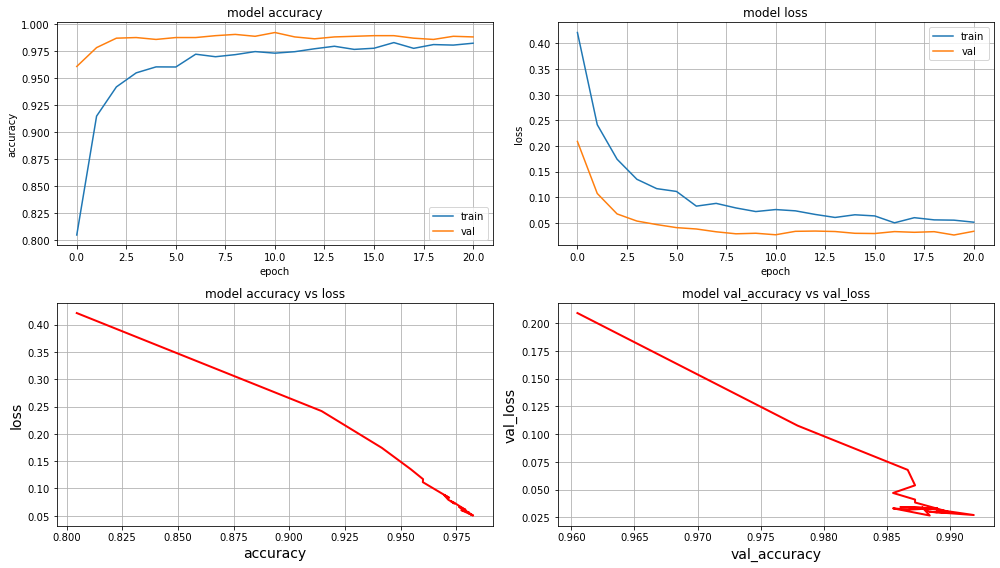

In [6]:
from audace.plotters import plot_nn_learning_curves

plot_nn_learning_curves(history)

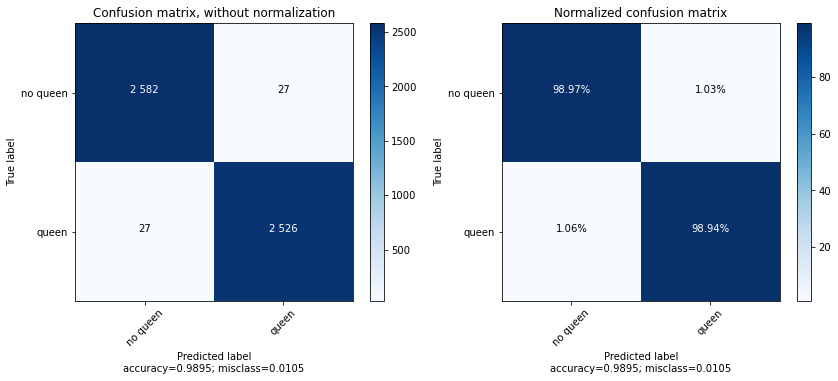

In [7]:
from audace.plotters import nn_full_report

nn_full_report(model, X_test, y_test, target_names = ['no queen', 'queen'])

In [8]:
from sklearn import metrics
import numpy as np

#Predict the response for test dataset
iprint('>>>>> Predict')
y_pred = model.predict(X_test).flatten().round()


# Display information about the classifier performance
iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
iprint("Precision :",metrics.precision_score(y_test, y_pred))
iprint("Recall    :",metrics.recall_score(y_test, y_pred))
iprint("F-Measure :",metrics.f1_score(y_test, y_pred))

[2020-09-02/15:18:24.002|08.9%|89.5%|0.48GB] >>>>> Predict
[2020-09-02/15:18:24.135|31.9%|89.5%|0.48GB] Accuracy  : 0.9895389383959705
[2020-09-02/15:18:24.138|00.0%|89.5%|0.48GB] Precision : 0.9894242068155111
[2020-09-02/15:18:24.141|00.0%|89.5%|0.48GB] Recall    : 0.9894242068155111
[2020-09-02/15:18:24.144|00.0%|89.5%|0.48GB] F-Measure : 0.9894242068155111


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 880)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 7048      
_________________________________________________________________
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0

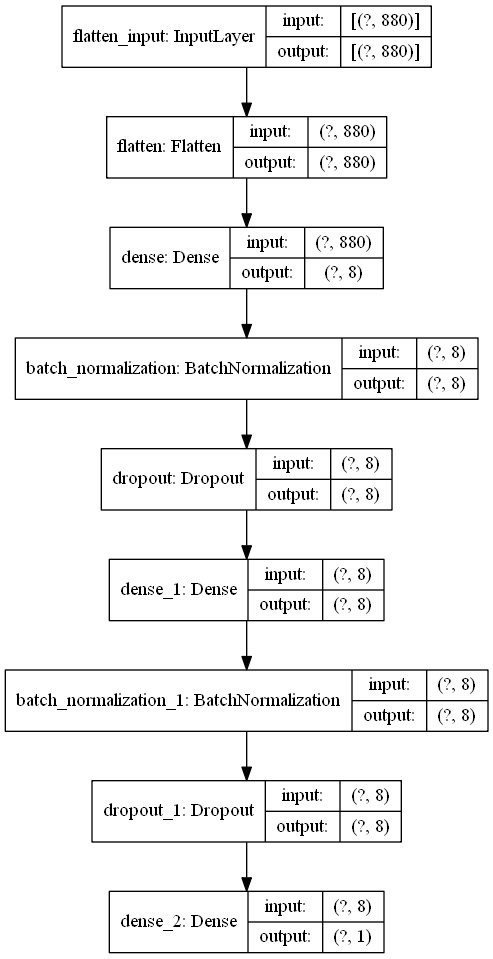

In [9]:
keras.utils.plot_model(model, "mlp.png", show_shapes=True)